### 6장 모델 평가와 하이퍼파라미터 튜닝의 모범 사례
- 6.1 파이프라인을 사용한 효율적인 워크플로
- 6.2 k-겹 교차 검증을 사용한 모델 성능 평가
- 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅
- 6.4 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
- 6.5 여러 가지 성능 평가 지표
- 6.6 불균형한 클래스 다루기
--- 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
## Wisconsin Diagnostic Breast Cancer
## column 0~1은 id와 진단결과(M: 악성, B: 양성), 2~31는 세포핵 디지털 이미지의 실수값 
df = pd.read_csv('data/wdbc.data', header = None)
print(df.shape)
df.head()

(569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
## 데이터셋 준비 : label encoding, train/test split
## 사실 사이킷런에는 M, B를 그대로 넣어도 알아서 encoding하므로, 굳이 LabelEncoder를 쓸 필요 없다. 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
X = df.loc[:, 2:].values 
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)
print('-target =', le.classes_)
print('-encoded target =', le.transform(le.classes_))
print('-y sample = ', y[:20])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
print('-X_train size =', X_train.shape)
print('-X_test size =', X_test.shape)
print('-y_train size =', y_train.shape)
print('-y_train size =', y_test.shape)

-target = ['B' 'M']
-encoded target = [0 1]
-y sample =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
-X_train size = (455, 30)
-X_test size = (114, 30)
-y_train size = (455,)
-y_train size = (114,)


---
#### 1. Pipe line : 표준화 > PCA > LogisticRegression을 한방에 
---

In [4]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline 

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components = 2), LogisticRegression(random_state = 42)) 
pipe_lr.fit(X_train, y_train)

print('-train score = ', pipe_lr.score(X_train, y_train))
print('-test score = ', pipe_lr.score(X_test, y_test))

-train score =  0.9494505494505494
-test score =  0.9473684210526315


In [12]:
## 참고. pipe_line 시각화 : set_config 
from sklearn import set_config 
set_config(display = 'diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

---
#### 2. k-fold cross validation 
- hold out cross-validation : 데이터셋을 training/validation/test set로 나눈다. 
- k-fold cross-validation : 중복을 허용하지 않고, k개의 폴드로 랜덤하게 나누어 교차검증한다. 
- stratified k-fold cross-validation : class 비율이 동등하지 않을때, 폴드간 class 비율이 일정하게 만든다. 
---

In [6]:
## k-fold 방식에서는 train set이 존재하지 않으므로, accuracy = test accuracy임 
from sklearn.model_selection import cross_validate 
scores = cross_validate(estimator = pipe_lr, X=X_train, y=y_train, 
                        scoring = ['accuracy'], cv = 10, n_jobs = -1 )  ## cv=10 : 10-fold, n__jobs=-1 : use all core 

np.mean(scores['test_accuracy'])

0.944927536231884

----
#### 3. learning curve 또는 validation curve 
- under fitting에 대한 대처 : prameters 갯수를 늘인다. 즉 추가적인 특성을 수집하거나, regression/SVM 모델의 경우 규제강도를 줄인다. 
- over fitting에 대한 대처  : 더 많은 훈련데이터를 모으거나, 모델 복잡도를 낮춘다. 규제강도를 높이거나, 규제가 없는 모델이라면 특성갯수를 줄인다. 
----

In [7]:
pipe_lr = make_pipeline(StandardScaler(), 
                        LogisticRegression(penalty = 'l2', random_state = 42)) ## L2(Ridge 규제 적용)

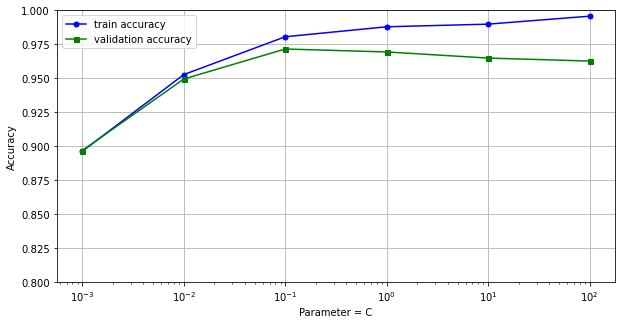

In [8]:
## logisticRegression의 매개변수 C(규제강도) 변화에 대한 validation curve 
from sklearn.model_selection import validation_curve 
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores =  validation_curve(
                             estimator = pipe_lr, X=X_train, y=y_train, 
                             param_name = 'logisticregression__C',   ##평가대상 매개변수 지정 
                             param_range = param_range, cv=10, n_jobs = -1 ) 

train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

plt.figure(figsize=(10, 5))
plt.plot(param_range, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'train accuracy')
plt.plot(param_range, test_mean, color = 'green', marker = 's', markersize = 5, label = 'validation accuracy')
plt.xscale('log')
plt.xlabel('Parameter = C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.legend()
plt.grid()
plt.show()

- C >= 1로 규제가 약해지면, overfitting이 발생한다. 

----
#### 4. GridSearchCV : hyperparameter 최적화 
- 리스트로 지정된 hyperparameters를 모두 조사하여, 최적 hyperparameters를 찾는다. 
- RandomizedSearchCV : 샘플링 가능한 분포를 입력받아, 최적 hyperparameters를 찾는다. 
----

In [9]:
## SVC의 커널로써 linear와 rbf중 더 우수한 것을 찾는다. 
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state = 42))

## 튜닝하려는 매개변수들을 리스트로 지정  
## gamma : 가우시안 rbf함수의 표준편차와 관련, 클수록 작은 표준편차를 가짐. 즉, gamma가 클수록 한 데이터 포인터들이 영향력을 행사하는 거리가 짧아짐 
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']}, 
              {'svc__C': param_range, 
               'svc__kernel': ['rbf'], 
               'svc__gamma': param_range} ]             

## refit = True : 최적 파라미터를 찾은 후, 입력값을 최적 파라미터로 재학습 (false인 경우는 최적변수를 찾기만 함)
gs = GridSearchCV(estimator = pipe_svc, 
                  param_grid = param_grid, 
                  scoring = 'accuracy', 
                  cv = 10, refit = True, n_jobs = -1) 

gs = gs.fit(X_train, y_train)
print('-Best Accuracy =', gs.best_score_)
print('-Best Parameters =', gs.best_params_)

-Best Accuracy = 0.9757004830917875
-Best Parameters = {'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [10]:
## 앞서 훈련된 best 매개변수들로 훈련시키고, test dataset으로 검증 
## refit = True로 지정했으므로 이미 best_params_를 사용해 훈련된 결과가 저장되어 있다. (*clf.fit(X_rain, y_trian)할 필요없다.)
clf = gs.best_estimator_
#clf.fit(X_train, y_train)
print('-train accuracy =', clf.score(X_train, y_train))
print('-test accuracy =', clf.score(X_test, y_test))

-train accuracy = 0.9934065934065934
-test accuracy = 0.956140350877193


In [15]:
## RandomizedSearchCV는 GridSearchCV에 비해 적은 자원으로 보다 효율적으로 계산을 수행한다. 
## GridSearchCV는 매개변수들을 리스트로 받는 반면, RandomizedSearchCV는 분포로 받는다. 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.utils.fixes import loguniform 

distribution = loguniform(0.0001, 1000.0)
param_dist = [{'svc__C': distribution, 
               'svc__kernel': ['linear']}, 
              {'svc__C': distribution, 
               'svc__kernel': ['rbf'], 
               'svc__gamma': distribution} ]             

rs = RandomizedSearchCV(estimator = pipe_svc, 
                        param_distributions = param_dist, 
                        n_iter = 30,  cv = 10, n_jobs = -1, random_state = 42) 

rs = rs.fit(X_train, y_train)
print('-Best Accuracy =', rs.best_score_)
print('-Best Parameters =', rs.best_params_)

-Best Accuracy = 0.9736714975845411
-Best Parameters = {'svc__C': 0.06295450333384249, 'svc__kernel': 'linear'}


In [16]:
rlf = rs.best_estimator_
#rlf.fit(X_train, y_train)
print('-train accuracy =', rlf.score(X_train, y_train))
print('-test accuracy =', rlf.score(X_test, y_test))

-train accuracy = 0.978021978021978
-test accuracy = 0.9824561403508771


----
#### 5. nested_cross_validation (중첩교차검증)
----

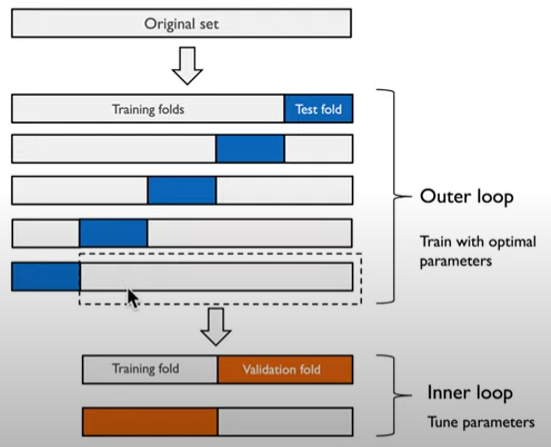

In [18]:
## 개념 : 바깥쪽 루프의 5-fold 교차검증 x 안쪽루프의 2-fold 
## 데이터가 적어 train/validation/test 검증결과를 신뢰하기 힘들때 사용하면 좋으나, 계산 리소스가 너무 많이 든다는 단점 
from IPython.display import Image 
Image('img/nested_cross-validation.PNG', width=500) 

In [21]:
## svc 모델에 nested crodd-validation 사용 예시 
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(estimator = pipe_svc, 
                  param_grid = param_grid, 
                  scoring = 'accuracy', 
                  cv = 2, n_jobs = -1) 

scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

print('Average accuracy =', np.mean(scores))
print('Std of accuracy =', np.std(scores))

Average accuracy = 0.9736263736263737
Std of accuracy = 0.013186813186813185


In [23]:
## tree 모델에 nested crodd-validation 사용 예시 
## tree 모델은 변수 표준화 불필요 
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 42), 
                  param_grid = [{'max_depth': [1,2,3,4,5,6,7,None]}], ##최적의 트리 깊이를 구하는 문제 
                  scoring = 'accuracy', 
                  cv = 2, n_jobs = -1) 

scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

print('Average accuracy =', np.mean(scores))
print('Std of accuracy =', np.std(scores))

Average accuracy = 0.9274725274725274
Std of accuracy = 0.035164835164835165


---
#### 6. model 성능평가 지표 
- Precision : 정밀도, Positive로 예측한 것중 Real positive의 비율 (모형정확도 중시, Risk 감수 ex. 정상 메일을 스팸으로 분류하면 안된다.) 
- Recall : 재현율, Real Positive중 Positive로 예측한 비율 (모형정확도 보다 Risk 감소가 더 중요한 경우 ex. 암환자를 놓쳐서는안된다.) 
- F1 : Precision과 REcall의 균형 
---

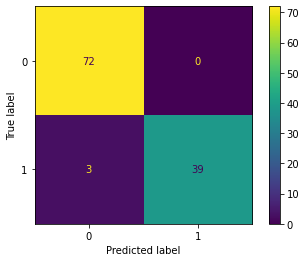

<Figure size 720x720 with 0 Axes>

In [36]:
## plot_confusion_matrix : 오차행렬 그리기, normalize 옵션을 사용하여 정규화 확률 출력 가능함 
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe_svc, X_test, y_test)
plt.show()

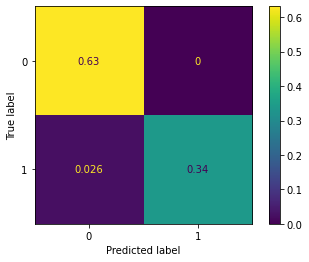

In [37]:
plot_confusion_matrix(pipe_svc, X_test, y_test, normalize = 'all')
plt.show()

In [47]:
## 사이킷런으로 Precision, Recall, F1 구하기 
## 계산을 위해 모형에 의해 예측된 y값(y_pred)가 필요하다. 
y_pred = pipe_svc.predict(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score

print('- precision_score =', precision_score(y_test, y_pred))
print('- recall_score =', recall_score(y_test, y_pred))
print('- f1_score =', f1_score(y_test, y_pred))

- precision_score = 1.0
- recall_score = 0.9285714285714286
- f1_score = 0.962962962962963


----
#### 7. ROC AUC 
- ROC curve : 그래프의 대각선은 랜덤 추축으로 해석, 따라서 대각선 아래 위치한 모델은 랜덤보다 나쁜 모델 
- ROC AUC   : ROC Area Under Curve (ROC커브 아래부분의 면적, 많을 수록 좋다. ~ max = 1) 
----

In [45]:
from sklearn.metrics import roc_auc_score
print('- roc_auc_score =', roc_auc_score(y_test, y_pred))

- roc_auc_score = 0.9642857142857143


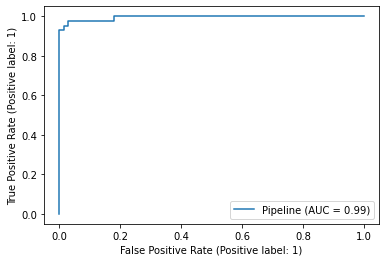

In [48]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(pipe_svc, X_test, y_test)
plt.show()

---
#### 8. 불균형한 클랙스 처리 : 예를들어 Positive가 90%라면, 랜덤하게 찍어도 정확도는 90%임
- 1) 소수 클래스에서 발생한 예측 오류에 큰 벌칙 부여 (class_weight = 'balanced'로 설정)
- 2) 소수 클래스의 샘플을 늘이거나, 다수 클래스의 샘플을 줄인다. 
---

In [59]:
## wdbc 데이터는 positive = 357, negative = 212로 구성되어 있다. (63:37) 
## 불규칙한 데이터셋 생성 : positive = 357, negative = 40 (9:1) 
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

y_imb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [61]:
## resample : 중복을 허용한 샘플 추출 방식, 소수 클래스 샘플을 늘이는데 사용 
## 클래스 1에 대해 클래스 0인 샘플갯수와 동일할때 까지 반복적으로 추출한다. 
from sklearn.utils import resample 

X_unsampled, y_unsampled = resample(X_imb[y_imb == 1], 
                                    y_imb[y_imb == 1],
                                    replace = True, 
                                    n_samples = X_imb[y_imb == 0].shape[0], 
                                    random_state = 42 )

y_unsampled

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [68]:
## 추출된 샘플을 클래스 0인 원래 샘플과 합친다. --> balanced sample 
X_bal = np.vstack((X[y==0], X_unsampled))
y_bal = np.hstack((y[y==0], y_unsampled))
y_bal

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,